# **Problem Statement: Abalone Age Prediction**

**Description:-**

Predicting the age of abalone from physical measurements. The age of abalone is
determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- a boring and time-consuming task. Other measurements, which are easier to obtain, are used to predict age. Further information, such as weather patterns and location (hence food availability) may be required to solve the problem.


**Attribute Information:**

Given is the attribute name, attribute type, measurement unit, and a brief description. The number of rings is the value to predict: either as a continuous value or as a classification problem.

**Name / Data Type / Measurement Unit / Description**

1- Sex / nominal / -- / M, F, and I (infant) 

2- Length / continuous / mm / Longest shell measurement

3- Diameter / continuous / mm / perpendicular to length

4- Height / continuous / mm / with meat in shell

5- Whole weight / continuous / grams / whole abalone

6- Shucked weight / continuous / grams / weight of meat

7- Viscera weight / continuous / grams / gut weight (after bleeding)

8- Shell weight / continuous / grams / after being dried

9- Rings / integer / -- / +1.5 gives the age in years

## Building a Regression Model

### Import libraries

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [2]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

In [3]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [5]:
import warnings
warnings.filterwarnings('ignore')

### Download and load the dataset

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
data = pd.read_csv('drive/My Drive/abalone.csv')

data.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


### Visualizations

Univariate Analysis

Univariate analysis provides an understanding in the characteristics of each feature in the data set. Different characteristics are computed for numerical and categorical data.

For the numerical features characteristics are standard deviation, skewness, kurtosis, percentile, interquartile range (IQR) and range.

In [14]:
stats_num = data.describe()
stats_num.loc['variance'] = data.select_dtypes(np.number).var().tolist()
stats_num.loc['skewness'] = data.select_dtypes(np.number).skew().tolist()
stats_num.loc['kurtosis'] = data.select_dtypes(np.number).kurtosis().tolist()
stats_num.loc['IQR'] = (data.select_dtypes(np.number).quantile(q=0.75) - data.select_dtypes(np.number).quantile(q=0.25)).tolist()
stats_num.loc['range'] = (data.select_dtypes(np.number).max() - data.select_dtypes(np.number).min()).tolist()

In [15]:
stats_num

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000
variance,0.014422,0.009849,0.001750,0.240481,0.049268,0.012015,0.019377,10.395266
skewness,-0.639873,-0.609198,3.128817,0.530959,0.719098,0.591852,0.620927,1.114102


The feature Height has an example with value  which doesn't make sense. This example needs to be removed.

In [16]:
for column in data.select_dtypes(np.number).columns:
    p_value = stats.shapiro(data[column].dropna())[1]
    if p_value <= 0.05:
        print(f'Null hypothesis of normality for feature {column} is rejected')
    else:
        print(f'Null hypothesis of normality for feature {column} is accepted')

Null hypothesis of normality for feature Length is rejected
Null hypothesis of normality for feature Diameter is rejected
Null hypothesis of normality for feature Height is rejected
Null hypothesis of normality for feature Whole weight is rejected
Null hypothesis of normality for feature Shucked weight is rejected
Null hypothesis of normality for feature Viscera weight is rejected
Null hypothesis of normality for feature Shell weight is rejected
Null hypothesis of normality for feature Rings is rejected


The null hypothesis is rejected for every feature and the target, meaning that they aren't modelled with a normal distribution.

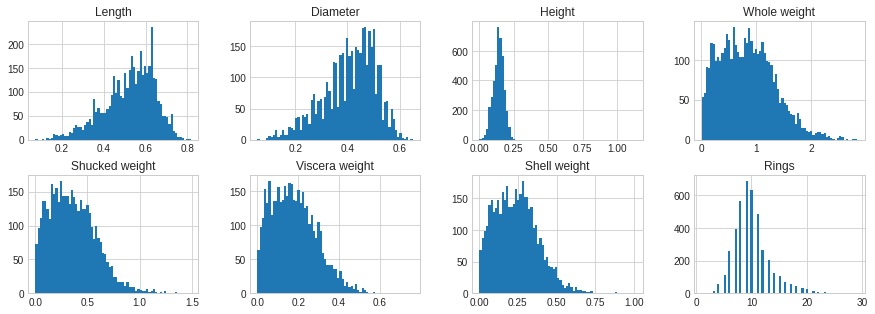

In [17]:
data.hist(figsize=(15,5), layout=(2,4), bins=70)
plt.show()

For the categorical features characteristics are count, cardinality, list of unique values, top and freq.

In [18]:
stats_cat = data.select_dtypes('object').describe()

In [19]:
stats_cat

,Sex
count,4177
unique,3
top,M
freq,1528


In [20]:
def uniqueValues(df):
    for column in df:
        unique_values = df[column].unique()
        print(f'Unique values of feature {column} are: {unique_values}')

uniqueValues(data.select_dtypes('object'))

Unique values of feature Sex are: ['M' 'F' 'I']


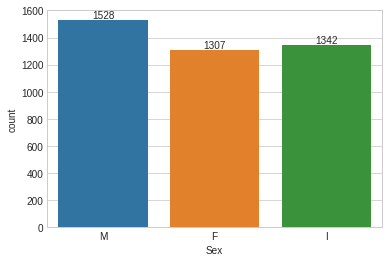

In [21]:
ax = sns.countplot(x=data['Sex'], data=data)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate(f'{p.get_height()}', (x.mean(), y), ha='center', va='bottom')
        
plt.show()

Bi-Variate Analysis

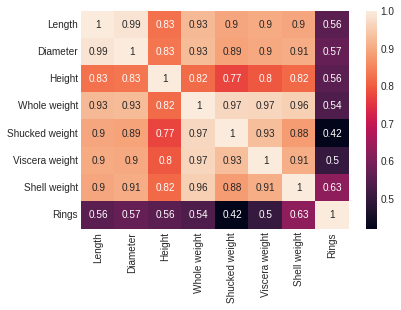

In [22]:
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

In this case it can be obsreved that there is somewhat weak linear relationship between each of the features and the target, so it is possible that linear models won't have a satisfactory performance.

Multi-Variate Analysis

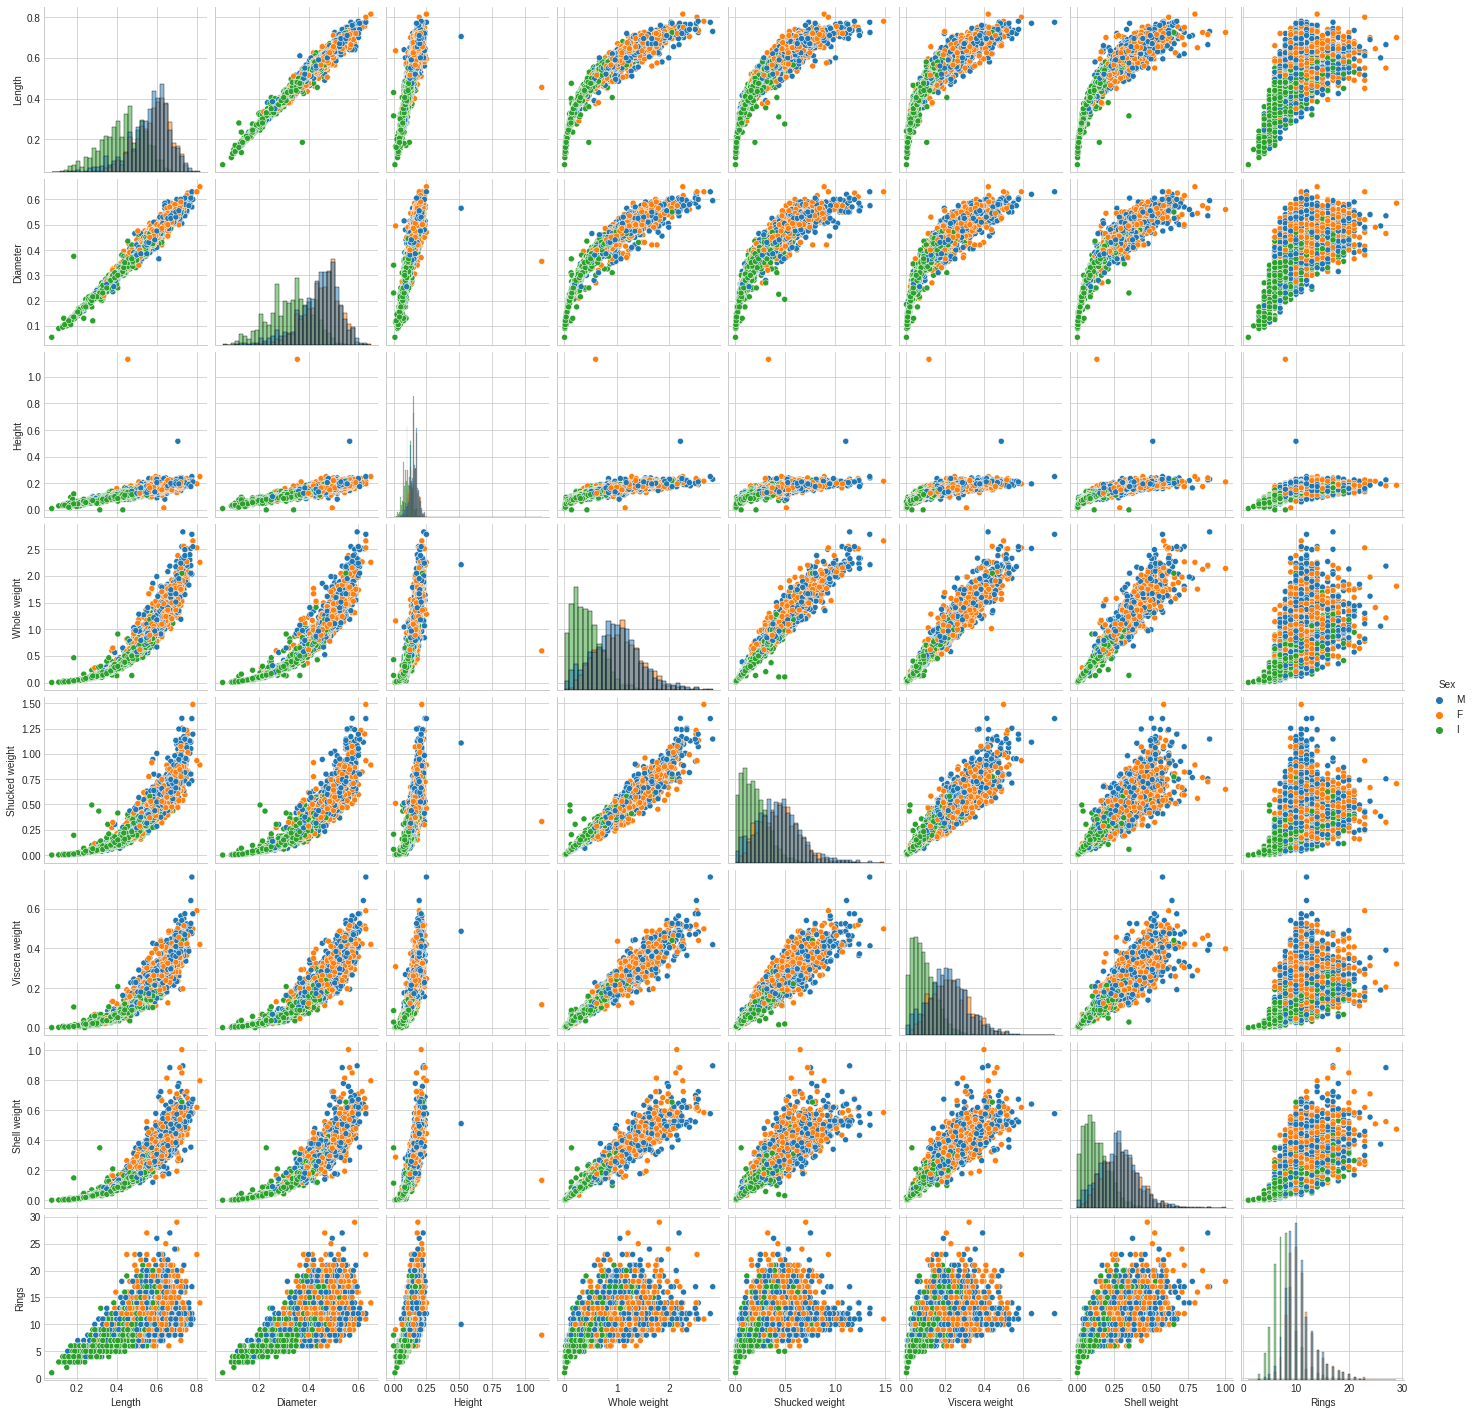

In [23]:
sns.pairplot(data, hue ='Sex', diag_kind='hist')
plt.show()

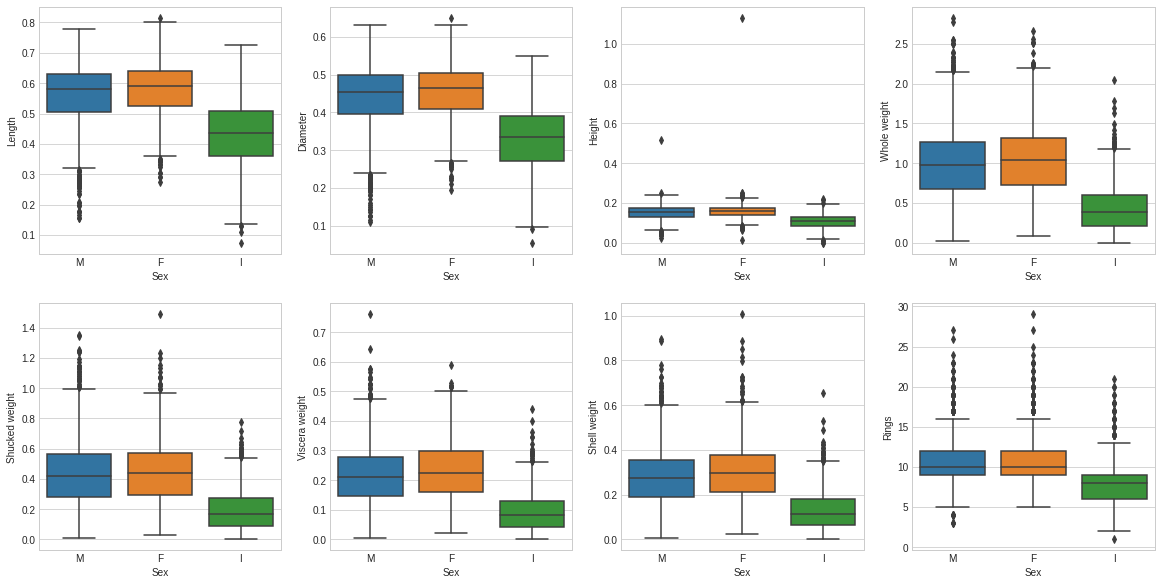

In [24]:
nnum = data.select_dtypes(np.number).shape[1]
cols = 4
rows = 2
fig, axes = plt.subplots(rows, cols, figsize=(20,10))

for ax in axes.flatten():
    ax.set_axis_off()
    
for column, ax in zip(data.select_dtypes(np.number).columns, axes.flatten()):
    sns.boxplot(x=data['Sex'], y=data[column], data=data, ax=ax)
    ax.set_axis_on()
    
plt.show()

### Descriptive statistics

In [26]:
data.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


### Handle the Missing values

In [27]:
data.isnull().sum()

Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Rings             0
dtype: int64

No missing values are found.

### Find the outliers and replace the outliers

It was found that Height has a value of , so the whole data set is cleaned from examples that have a zero value because a physical measurment cannot have such value.

In [28]:
data = data[(data != 0).all(axis=1)]

In [29]:
data.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4175.000000,4175.00000,4175.000000,4175.000000,4175.000000,4175.000000,4175.000000,4175.000000
mean,0.524065,0.40794,0.139583,0.829005,0.359476,0.180653,0.238834,9.935090
std,0.120069,0.09922,0.041725,0.490349,0.221954,0.109605,0.139212,3.224227
min,0.075000,0.05500,0.010000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.35000,0.115000,0.442250,0.186250,0.093500,0.130000,8.000000
50%,0.545000,0.42500,0.140000,0.800000,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.48000,0.165000,1.153500,0.502000,0.253000,0.328750,11.000000
max,0.815000,0.65000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


### Split the data into training and testing

In [30]:
train, test = train_test_split(data, test_size=0.15, random_state=0)

In [31]:
abaloneLen = len(data.index)
trainLen = len(train.index)
testLen = len(test.index)

trainPercent = np.round(trainLen/abaloneLen*100, 3)
print(trainPercent)
print(np.round(100 - trainPercent, 3))

print(abaloneLen, trainLen, testLen)

84.982
15.018
4175 3548 627


### Split the data into dependent and independent variables

In [32]:
X_train, y_train = train.drop('Rings', axis=1), train['Rings']
X_test, y_test = test.drop('Rings', axis=1), test['Rings']

### Check for Categorical columns and perform encoding

In [33]:
numerical_transformer = Pipeline([
    ('standardization', StandardScaler()),
    ('pca', PCA())
])

preprocessor = ColumnTransformer([
    ('1hot', OneHotEncoder(sparse=False), make_column_selector(dtype_include='object')),
    ('num', numerical_transformer, make_column_selector(dtype_include='number'))
])

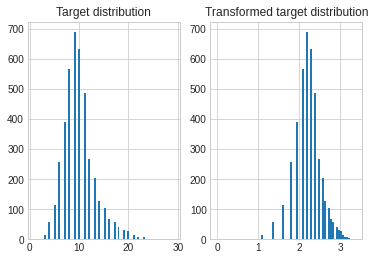

In [34]:
plt.subplot(1,2,1)
plt.hist(data['Rings'], bins=70)
plt.title('Target distribution')

plt.subplot(1,2,2)
plt.hist(np.log(data['Rings']), bins=70)
plt.title('Transformed target distribution')
plt.show()

In [35]:
y_train_log, y_test_log = np.log(y_train), np.log(y_test)

### Scale the independent variables

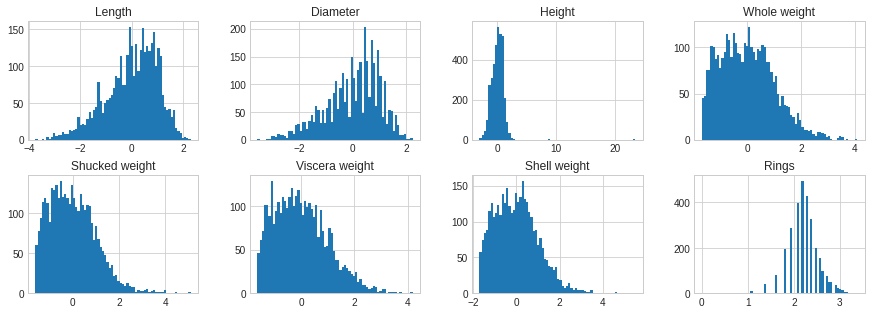

In [36]:
check = pd.DataFrame(data=StandardScaler().fit_transform(X_train.drop('Sex', axis=1)), columns=X_train.drop('Sex', axis=1).columns)
check['Rings'] = y_train_log

check.hist(figsize=(15,5), layout=(2,4), bins=70)
plt.show()

### Build the Model

In [37]:
from sklearn.model_selection import RepeatedKFold
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import PowerTransformer

X, y = data.iloc[:, :-1], data.iloc[:, -1]

# minimally prepare dataset
y = y.astype('float32')

# evaluate model
baseline = SVR(kernel='rbf',gamma='scale',C=10)
transform = ColumnTransformer(transformers=[('c', OneHotEncoder(), [0])], remainder='passthrough')
target = TransformedTargetRegressor(regressor=baseline, transformer=PowerTransformer(), check_inverse=False)
pipeline = Pipeline(steps=[('ColumnTransformer',transform), ('Model',target)])
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
r2_scores = cross_val_score(pipeline, X, y, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
r2_scores = np.absolute(r2_scores)
print('Baseline: %.3f (+/-%.3f)' % (np.mean(r2_scores), np.std(r2_scores)))

Baseline: 0.562 (+/-0.033)


The regression algorithms that are trained to solve the problem are:

1. k-Nearest Neighbors; 

2. Ridge Regression;

3. Support Vector Machines;

4. Decision Trees;

5. Random Forests;

6. Gradient Boosting for regression;

7. XGBoost Regressor.

10-fold cross-validation is used as a measure to prevent overfitting.

In [38]:
models = [
    KNeighborsRegressor(n_jobs=-1),
    Ridge(),
    SVR(),
    DecisionTreeRegressor(random_state=0),
    RandomForestRegressor(n_jobs=-1, random_state=0),
    GradientBoostingRegressor(random_state=0),
    XGBRegressor()
]

### Train the Model

In [39]:
regressors = []

for model in models:
    regressor = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
    regressors.append(regressor)

In [40]:
model_names = [
    '      k-Neighbors Regressor',
    '           Ridge Regression',
    '   Support Vector Regressor',
    '    Decision Tree Regressor',
    '    Random Forest Regressor',
    'Gradient Boosting Regressor',
    '          XGBoost Regressor'
]

for name, regressor in zip(model_names, regressors):
    regressor.fit(X_train, y_train_log)
    score = cross_val_score(estimator=regressor, X=X_train, y=y_train_log, cv=10, scoring='r2')
    print(f"{name}: {score.mean():.4f} (+/-{score.std():.4f})")

      k-Neighbors Regressor: 0.5951 (+/-0.0425)
           Ridge Regression: 0.5866 (+/-0.0425)
   Support Vector Regressor: 0.6564 (+/-0.0359)
    Decision Tree Regressor: 0.3552 (+/-0.0959)
    Random Forest Regressor: 0.6545 (+/-0.0386)
Gradient Boosting Regressor: 0.6628 (+/-0.0338)
[15:17:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:17:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:17:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:17:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:17:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:17:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linea

### Test the Model

In [41]:
MAEs = []
MSEs = []
RMSEs = [] # If squared=True returns MSE value, if squared=False returns RMSE value.
R2_scores = []

In [42]:
for regressor in regressors:
    MAEs.append(mean_absolute_error(y_test_log, regressor.predict(X_test)))
    MSEs.append(mean_squared_error(y_test_log, regressor.predict(X_test)))
    RMSEs.append(mean_squared_error(y_test_log, regressor.predict(X_test), squared=False))
    R2_scores.append(r2_score(y_test_log, regressor.predict(X_test)))

### Measure the performance using metrics

In [43]:
scoring_summary = pd.DataFrame({
    'Model': [name.strip() for name in model_names],
    'MAE score': MAEs,
    'MSE score': MSEs,
    'RMSE': RMSEs,
    'R2 Score': R2_scores
})

In [44]:
scoring_summary.sort_values('R2 Score', ascending=False)

,Model,MAE score,MSE score,RMSE,R2 Score
2,Support Vector Regressor,0.141558,0.033549,0.183163,0.655027
6,XGBoost Regressor,0.140963,0.033856,0.183999,0.651870
5,Gradient Boosting Regressor,0.141429,0.034010,0.184418,0.650283
4,Random Forest Regressor,0.145248,0.035480,0.188362,0.635164
0,k-Neighbors Regressor,0.153654,0.040948,0.202356,0.578944
1,Ridge Regression,0.159779,0.042259,0.205570,0.565463
3,Decision Tree Regressor,0.191218,0.064029,0.253039,0.341607
